<a href="https://colab.research.google.com/github/DARKINOO/Pytorch_practice/blob/main/ann_fashion_mnist_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#Set random seeds for reproducability
torch.manual_seed(42)

In [3]:
#Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [4]:
df = pd.read_csv('fashion-mnist_train.csv')

In [5]:
df.head()

label  pixel1  pixel2  pixel3  ...  pixel781  pixel782  pixel783  pixel784
0      2       0       0       0  ...         0         0         0         0
1      9       0       0       0  ...         0         0         0         0
2      6       0       0       0  ...         0         0         0         0
3      0       0       0       0  ...         0         0         0         0
4      3       0       0       0  ...         0         0         0         0

[5 rows x 785 columns]

In [6]:
df.shape

(60000, 785)

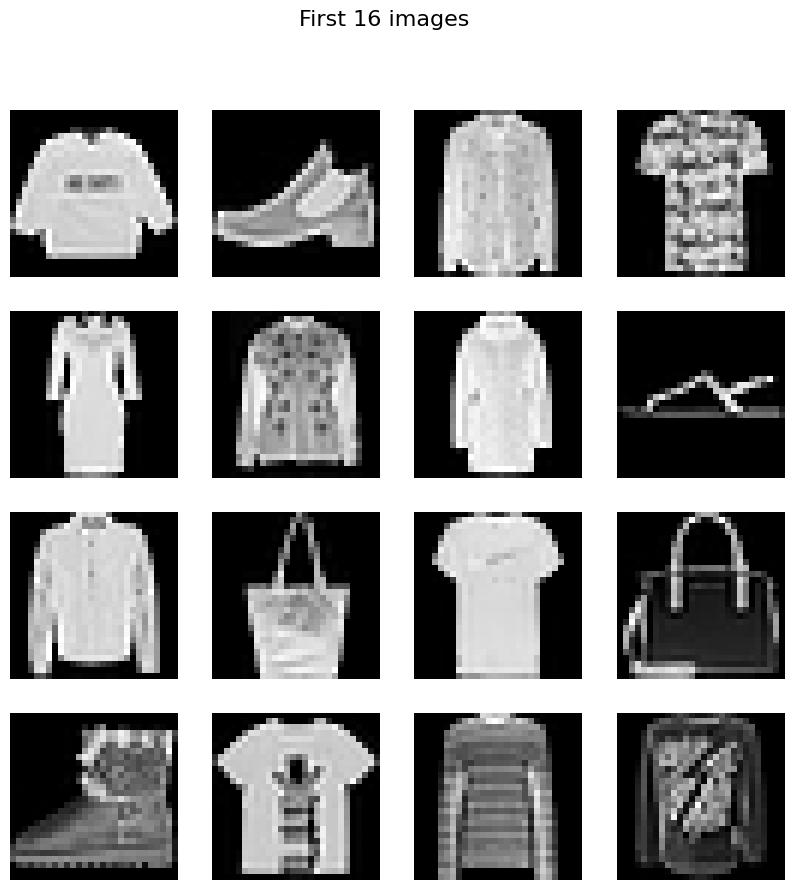

In [7]:
#Crate a 4x4 grid of images
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images", fontsize=16)

#plot the first 16 images from the dataset
for i, ax in enumerate(axes.flatten()):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

In [8]:
#train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [12]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):

    #Convert to Pytorch tensors
    self.features = torch.tensor(features,dtype=torch.float32)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]


In [13]:
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [22]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=False, pin_memory=True)

In [25]:
len(train_loader)

750

In [17]:
class MyNN(nn.Module):

  def __init__(self,num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,10)
    )

  def forward(self,x):
    return self.model(x)

In [18]:
learning_rate = 0.1
epochs = 100

In [19]:
# instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)
# loss fxn
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(),lr=learning_rate)

In [24]:
#training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    #move data to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    #forward pass
    outputs = model(batch_features)
    loss = criterion(outputs,batch_labels)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_epoch_loss/len(train_loader)}")

Epoch 1/100, Loss: 0.05285909898827473
Epoch 2/100, Loss: 0.054866243744269017
Epoch 3/100, Loss: 0.051939721821186446
Epoch 4/100, Loss: 0.04894435012837251
Epoch 5/100, Loss: 0.053177512943434216
Epoch 6/100, Loss: 0.05029181652252252
Epoch 7/100, Loss: 0.0457358930556414
Epoch 8/100, Loss: 0.05078059663856402
Epoch 9/100, Loss: 0.04509518222960954
Epoch 10/100, Loss: 0.04606405368400738
Epoch 11/100, Loss: 0.04957254035351798
Epoch 12/100, Loss: 0.04542506793420762
Epoch 13/100, Loss: 0.04176555281629165
Epoch 14/100, Loss: 0.03622649629375276
Epoch 15/100, Loss: 0.043450933933025224
Epoch 16/100, Loss: 0.043850630840053785
Epoch 17/100, Loss: 0.043390817812023065
Epoch 18/100, Loss: 0.04306940726578856
Epoch 19/100, Loss: 0.04131880047886322
Epoch 20/100, Loss: 0.04339049716386944
Epoch 21/100, Loss: 0.03813910108944401
Epoch 22/100, Loss: 0.0370158121464774
Epoch 23/100, Loss: 0.03578100256295875
Epoch 24/100, Loss: 0.032613002960259714
Epoch 25/100, Loss: 0.0343767722476429
Epoch

In [26]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [30]:
#evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = model(batch_features)

    _, predcited = torch.max(outputs,1)

    total = total + batch_labels.shape[0]

    correct = correct + (predcited == batch_labels).sum().item()

print(f"Accuracy: {correct/total}")

Accuracy: 0.8936666666666667
